# Q1: Place Accessibility

## Recap

After the process in QGIS, I have the data of the area that people can can arrive in 15 minutes from Shenzhen Metro stations  via taking bus, cycling and walking. Following, I want to know the place accessiblity difference of different townships.

## Loading packages

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import libpysal as ps
from shapely.geometry import Point

from descartes import PolygonPatch
import folium
import geopandas as gpd
from geopy.geocoders import Nominatim
from ipywidgets import interact, fixed, widgets
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import osmnx as ox
import pandas as pd
from shapely import geometry
from pandas.core.frame import DataFrame

import statsmodels.api as sm
import scipy.stats as sps
import math
from scipy import stats

## Processing data

### Loading documents

In [51]:
# township border
shp=gpd.read_file("input_data/street_level_shp/深圳市_乡镇边界.shp") 

# multiple features including every stations' result
shpb=gpd.read_file("input_data/final_all_station_15_bus_multiple_feature.shp") 
shpc=gpd.read_file("input_data/final_all_station_15_cycling_multiple_feature.shp") 
shpw=gpd.read_file("input_data/final_all_station_15_walking_multiple_feature.shp") 

# one feature only including the area that 15 min can arrive
shpb_all=gpd.read_file("input_data/final_all_station_15_bus_single_feature.shp") 
shpc_all=gpd.read_file("input_data/final_all_station_15_cycling_single_feature.shp") 
shpw_all=gpd.read_file("input_data/final_all_station_15_walking_single_feature.shp") 

# population of each townships
pop=pd.read_csv("input_data/Shenzhen_population.csv")

# office building in Shezhen (from 'API reprocess')
off=gpd.read_file("input_data/street_level_shp/office.shp") 

# governmnet office in Shenzhen
gov=gpd.read_file("input_data/street_level_shp/深圳市_政府机关.shp") 

### Make sure they all in the same CRS

In [3]:
shp = shp.to_crs("EPSG:4326")

In [4]:
shp = shp.to_crs("EPSG:3857")
shpw = shpw.to_crs("EPSG:3857")
shpc = shpc.to_crs("EPSG:3857")
shpb = shpb.to_crs("EPSG:3857")
shpw_all = shpw_all.to_crs("EPSG:3857")
shpc_all = shpc_all.to_crs("EPSG:3857")
shpb_all = shpb_all.to_crs("EPSG:3857")
off = off.to_crs("EPSG:3857")
gov = gov.to_crs("EPSG:3857")

### Split data into township level

In [5]:
sub_bus_all=[]
sub_cyc_all=[]
sub_walk_all=[]
sub_bus_area_all=[]
sub_cyc_area_all=[]
sub_walk_area_all=[]
sub_divide_area_all=[]
sub_off=[]
sub_gov=[]

for i in range (len(shp['Name'])):
    
    # Find out how many stations each township has within a 15-minute bus ride.
    bus_sub_shp=gpd.clip(shpb,shp.iloc[[i]])
    bus_sub_count=len(bus_sub_shp.index)
    print(bus_sub_count)
    
    # Find out how many stations each township has within a 15-minute bike ride.
    cyc_sub_shp=gpd.clip(shpc,shp.iloc[[i]])
    cyc_sub_count=len(cyc_sub_shp.index)
    print(cyc_sub_count)
    
    # Find out how many metro stations are within a 15-minute walk in each township.
    walk_sub_shp=gpd.clip(shpw,shp.iloc[[i]])
    walk_sub_count=len(walk_sub_shp.index)
    print(walk_sub_count)
    
    
    # Calculate the area of each township that can reach at least one metro station within 15 minutes bus.
    bus_sub_area_shp=gpd.clip(shpb_all,shp.iloc[[i]])
    if bus_sub_count==0:
        sub_bus_area=0
    else:
        sub_bus_area=bus_sub_area_shp.loc[0,'geometry'].area
    print(sub_bus_area)
    
    # Calculate the area of each township that can reach at least one metro station within 15 minutes cycling.
    cyc_sub_area_shp=gpd.clip(shpc_all,shp.iloc[[i]])
    if cyc_sub_count==0:
        sub_cyc_area=0
    else:
        sub_cyc_area=cyc_sub_area_shp.loc[0,'geometry'].area
    print(sub_cyc_area)
    
    # Calculate the area of each township that can reach at least one metro station within 15 minutes walking.
    walk_sub_area_shp=gpd.clip(shpw_all,shp.iloc[[i]])
    if walk_sub_count==0:
        sub_walk_area=0
    else:
        sub_walk_area=walk_sub_area_shp.loc[0,'geometry'].area
    print(sub_walk_area)
    
    # Calculate the area of each township.
    sub_divide_area=shp.loc[i,'geometry'].area
    print(sub_divide_area)
    
    # Calculate the office building of each township have.
    sub_divide_off=gpd.clip(off,shp.iloc[[i]])
    off_sub_count=len(sub_divide_off.index)
    print(off_sub_count)
    
    # Calculate the government office of each township have.
    sub_divide_gov=gpd.clip(gov,shp.iloc[[i]])
    gov_sub_count=len(sub_divide_gov.index)
    print(gov_sub_count)
    
    sub_bus_all.append(bus_sub_count)
    sub_cyc_all.append(cyc_sub_count)
    sub_walk_all.append(walk_sub_count)
    sub_bus_area_all.append(sub_bus_area)
    sub_cyc_area_all.append(sub_cyc_area)
    sub_walk_area_all.append(sub_walk_area)
    sub_divide_area_all.append(sub_divide_area)
    sub_off.append(off_sub_count)
    sub_gov.append(gov_sub_count)

194
52
19
18983009.213056974
19343083.225637875
12394046.311436525
21917769.208713096
28
11
164
60
17
17391730.67859038
17763858.221698787
14310443.85759966
18179554.542086437
59
33
48
9
1
26134196.793613363
18664230.33695536
764694.1737289198
26134196.793613356
6
5
44
7
0
25470255.309280913
10442869.53301561
0
25470255.309280924
1
4
58
9
3
25677064.432687704
16260831.902353978
3435204.355164866
34442058.43819458
3
13
26
11
4
27850171.630748425
18237179.383948285
6014343.286131466
27850171.63074843
13
36
23
10
5
34526030.50956578
29395194.13460455
4485150.933020451
47542333.57198469
9
1
31
15
4
21328552.21293992
20839338.141528662
4175198.908255674
21328552.212939937
5
3
136
48
14
11665600.345675528
11665600.353391472
5624716.927856479
11665600.364145873
2
94
94
33
11
17665842.58746711
17623438.681957673
4897569.209344097
19912936.760409094
9
42
78
20
5
5486166.774413677
5646869.287682732
4479984.573799854
5646869.345831706
4
22
171
47
6
45898487.7082667
35623780.52058138
4936373.38595

### Put all data into a dataframe

In [6]:
c={'Name':shp['Name'],
  "bus_arrive_in_15_min":sub_bus_all,
  "cycling_arrive_in_15_min":sub_cyc_all,
  "walking_arrive_in_15_min":sub_walk_all,
  "bus_arrive_area":sub_bus_area_all,
  "cycling_arrive_area":sub_cyc_area_all,
  "walking_arrive_area":sub_walk_area_all,
  "area":sub_divide_area_all,
  "office_building":sub_off,
  "gov":sub_gov}
final=DataFrame(c)

In [7]:
final

,Name,bus_arrive_in_15_min,cycling_arrive_in_15_min,walking_arrive_in_15_min,bus_arrive_area,cycling_arrive_area,walking_arrive_area,area,office_building,gov
0,沙河街道,194,52,19,1.898301e+07,1.934308e+07,1.239405e+07,2.191777e+07,28,11
1,粤海街道,164,60,17,1.739173e+07,1.776386e+07,1.431044e+07,1.817955e+07,59,33
2,凤凰街道,48,9,1,2.613420e+07,1.866423e+07,7.646942e+05,2.613420e+07,6,5
3,玉塘街道,44,7,0,2.547026e+07,1.044287e+07,0.000000e+00,2.547026e+07,1,4
4,光明街道,58,9,3,2.567706e+07,1.626083e+07,3.435204e+06,3.444206e+07,3,13
...,...,...,...,...,...,...,...,...,...,...
69,大鹏街道,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,8.930817e+07,0,28
70,南山街道,116,47,22,3.005199e+07,2.982976e+07,1.291327e+07,3.897741e+07,4,34
71,海山街道,72,6,2,7.130362e+06,7.419946e+06,3.411624e+06,8.902064e+06,2,144
72,盐田街道,57,6,4,4.150163e+07,2.131231e+07,4.171898e+06,5.389767e+07,4,22


# __________________________________________________________________________________________

## Merge and calculate

### Merge population data in to dataframe

In [8]:
pop

,Name,population
0,南园街道,121231
1,园岭街道,99858
2,福田街道,283052
3,沙头街道,265155
4,香蜜湖街道,156220
...,...,...
69,马峦街道,91214
70,碧岭街道,60139
71,葵涌街道,81656
72,大鹏街道,57402


In [9]:
merge_data=final.merge(pop, on=['Name'])
merge_data

,Name,bus_arrive_in_15_min,cycling_arrive_in_15_min,walking_arrive_in_15_min,bus_arrive_area,cycling_arrive_area,walking_arrive_area,area,office_building,gov,population
0,沙河街道,194,52,19,1.898301e+07,1.934308e+07,1.239405e+07,2.191777e+07,28,11,165707
1,粤海街道,164,60,17,1.739173e+07,1.776386e+07,1.431044e+07,1.817955e+07,59,33,240224
2,凤凰街道,48,9,1,2.613420e+07,1.866423e+07,7.646942e+05,2.613420e+07,6,5,155086
3,玉塘街道,44,7,0,2.547026e+07,1.044287e+07,0.000000e+00,2.547026e+07,1,4,213178
4,光明街道,58,9,3,2.567706e+07,1.626083e+07,3.435204e+06,3.444206e+07,3,13,111410
...,...,...,...,...,...,...,...,...,...,...,...
69,大鹏街道,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,8.930817e+07,0,28,57402
70,南山街道,116,47,22,3.005199e+07,2.982976e+07,1.291327e+07,3.897741e+07,4,34,332222
71,海山街道,72,6,2,7.130362e+06,7.419946e+06,3.411624e+06,8.902064e+06,2,144,57632
72,盐田街道,57,6,4,4.150163e+07,2.131231e+07,4.171898e+06,5.389767e+07,4,22,91723


### Calculate the data we need

In [10]:
# In each township, the percentage of the area that can reach at least one metro station by bus within 15 minutes in the total area
merge_data['bus_area_rate']=merge_data['bus_arrive_area']/merge_data['area']
# In each township, the percentage of the area that can reach at least one metro station by cycling within 15 minutes in the total area
merge_data['cycling_area_rate']=merge_data['cycling_arrive_area']/merge_data['area']
# In each township, the percentage of the area that can reach at least one metro station by walking within 15 minutes in the total area
merge_data['walking_area_rate']=merge_data['walking_arrive_area']/merge_data['area']

# In each township, the number of metro stations per capita by bus within 15 minutes.
merge_data['per_bus']=merge_data['bus_arrive_in_15_min']/merge_data['population']
# In each township, the number of metro stations per capita by bike within 15 minutes.
merge_data['per_cyc']=merge_data['cycling_arrive_in_15_min']/merge_data['population']
# In each township, the number of metro stations per capita by walk within 15 minutes.
merge_data['per_walk']=merge_data['walking_arrive_in_15_min']/merge_data['population']

# In each township, the number of office buildings per square meter.
merge_data['office_rate_by_area']=merge_data['office_building']/merge_data['area']
# In each township, the number of government offices per square meter.
merge_data['gov_rate_by_area']=merge_data['gov']/merge_data['area']
# In each township, the number of people per square meter.
merge_data['pop_rate_by_area']=merge_data['population']/merge_data['area']

In [11]:
mix = shp.merge(merge_data, on='Name', how='left')
mix

,OBJECTID,Name,Layer,gml_id,code,grade,Shape_Leng,Shape_Area,geometry,bus_arrive_in_15_min,...,population,bus_area_rate,cycling_area_rate,walking_area_rate,per_bus,per_cyc,per_walk,office_rate_by_area,gov_rate_by_area,pop_rate_by_area
0,1,沙河街道,乡镇,None,None,0,20040.978853,2.179247e+07,"POLYGON ((12689522.017 2576929.913, 12689523.0...",194,...,165707,0.866101,0.882530,0.565479,0.001171,0.000314,0.000115,1.277502e-06,5.018759e-07,0.007560
1,2,粤海街道,乡镇,None,None,0,19159.589736,1.807562e+07,"POLYGON ((12681992.942 2575205.739, 12681992.9...",164,...,240224,0.956664,0.977134,0.787172,0.000683,0.000250,0.000071,3.245404e-06,1.815226e-06,0.013214
2,13,凤凰街道,乡镇,layer_township_pg.15697,440311004000,4,29736.850664,2.598523e+07,"POLYGON ((12687831.657 2598168.054, 12687613.3...",48,...,155086,1.000000,0.714169,0.029260,0.000310,0.000058,0.000006,2.295843e-07,1.913202e-07,0.005934
3,14,玉塘街道,乡镇,layer_township_pg.15698,440311005000,4,29501.182969,2.532503e+07,"POLYGON ((12678475.143 2600485.832, 12678755.8...",44,...,213178,1.000000,0.410003,0.000000,0.000206,0.000033,0.000000,3.926148e-08,1.570459e-07,0.008370
4,15,光明街道,乡镇,layer_township_pg.15699,440311001000,4,30030.513705,3.424578e+07,"POLYGON ((12689126.525 2603202.310, 12689082.8...",58,...,111410,0.745515,0.472121,0.099739,0.000521,0.000081,0.000027,8.710281e-08,3.774455e-07,0.003235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,88,大鹏街道,乡镇,layer_township_pg.15773,440307010000,4,63412.662042,8.879811e+07,"POLYGON ((12738210.629 2583233.756, 12738302.3...",0,...,57402,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,3.135211e-07,0.000643
70,19,南山街道,乡镇,layer_township_pg.15704,440305002000,4,33035.172793,3.875446e+07,"MULTIPOLYGON (((12677486.804 2576818.864, 1267...",116,...,332222,0.771010,0.765309,0.331301,0.000349,0.000141,0.000066,1.026236e-07,8.723002e-07,0.008523
71,48,海山街道,乡镇,layer_township_pg.15733,440308004000,4,12242.843502,8.851195e+06,"POLYGON ((12717202.971 2578665.307, 12717007.7...",72,...,57632,0.800978,0.833508,0.383240,0.001249,0.000104,0.000035,2.246670e-07,1.617602e-05,0.006474
72,43,盐田街道,乡镇,layer_township_pg.15728,440308002000,4,32169.232404,5.358986e+07,"POLYGON ((12717171.245 2586205.839, 12717276.9...",57,...,91723,0.770008,0.395422,0.077404,0.000621,0.000065,0.000044,7.421470e-08,4.081809e-07,0.001702


# _______________________________________________________________________________________________________________

## Plot

<AxesSubplot:>

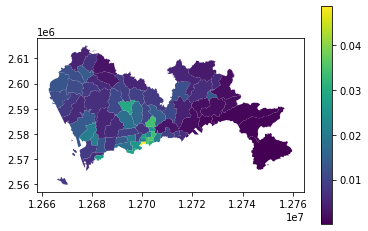

In [12]:
mix.plot("pop_rate_by_area", legend=True)

<AxesSubplot:>

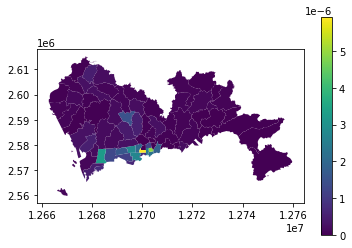

In [13]:
mix.plot("office_rate_by_area", legend=True)

<AxesSubplot:>

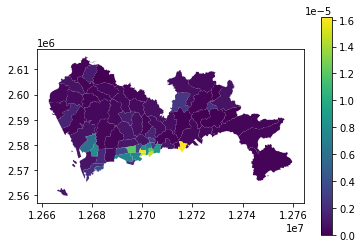

In [14]:
mix.plot("gov_rate_by_area", legend=True)

<AxesSubplot:>

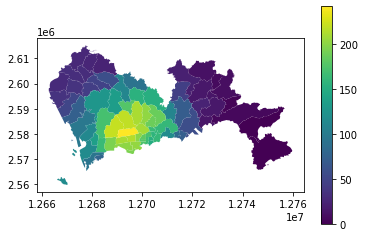

In [15]:
mix.plot("bus_arrive_in_15_min", legend=True)

<AxesSubplot:>

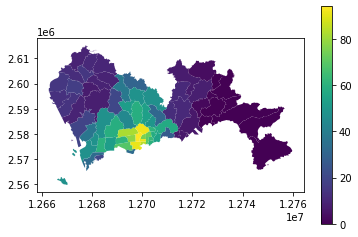

In [16]:
mix.plot("cycling_arrive_in_15_min", legend=True)

<AxesSubplot:>

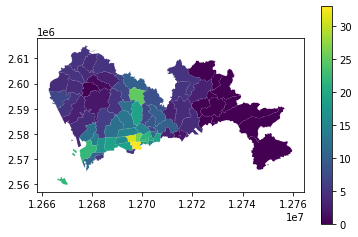

In [17]:
mix.plot("walking_arrive_in_15_min", legend=True)

<AxesSubplot:>

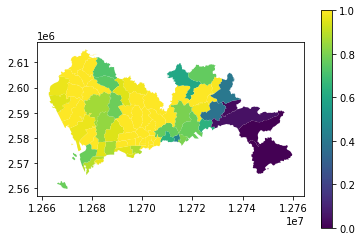

In [18]:
mix.plot("bus_area_rate", legend=True)

<AxesSubplot:>

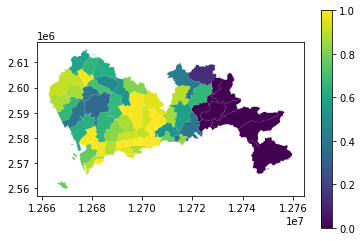

In [19]:
mix.plot("cycling_area_rate", legend=True)

<AxesSubplot:>

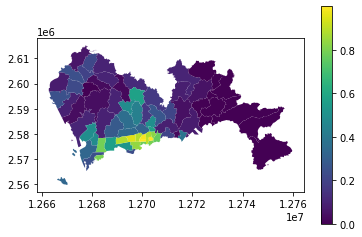

In [20]:
mix.plot("walking_area_rate", legend=True)

<AxesSubplot:>

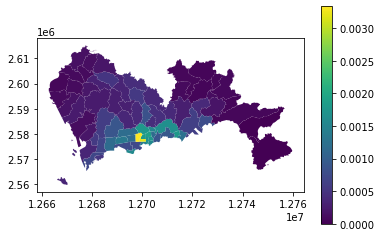

In [21]:
mix.plot("per_bus", legend=True)

<AxesSubplot:>

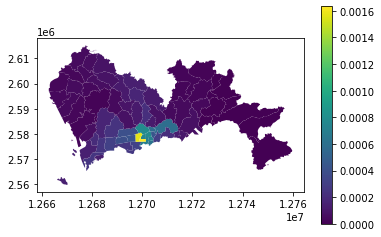

In [22]:
mix.plot("per_cyc", legend=True)

<AxesSubplot:>

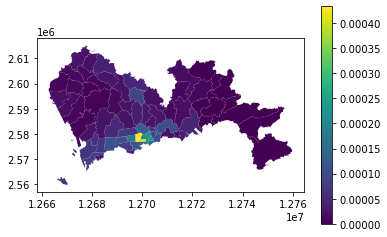

In [23]:
mix.plot("per_walk", legend=True)

# _________________________________________________________________________________________________________________________

## Multiple linear regression

### Data distribution

In [24]:
print(merge_data.describe())

       bus_arrive_in_15_min  cycling_arrive_in_15_min  \
count             74.000000                 74.000000   
mean             108.567568                 33.729730   
std               74.210009                 28.708882   
min                0.000000                  0.000000   
25%               32.750000                  9.000000   
50%              112.000000                 28.500000   
75%              172.750000                 57.750000   
max              242.000000                 94.000000   

       walking_arrive_in_15_min  bus_arrive_area  cycling_arrive_area  \
count                 74.000000     7.400000e+01         7.400000e+01   
mean                   9.108108     2.307246e+07         1.665453e+07   
std                    8.281962     1.639514e+07         1.263446e+07   
min                    0.000000     0.000000e+00         0.000000e+00   
25%                    3.000000     8.587078e+06         4.105461e+06   
50%                    5.500000     2.256147e+07

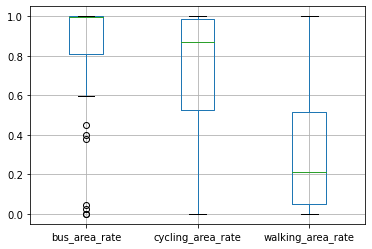

In [25]:
boxplot = merge_data.boxplot(column=['bus_area_rate','cycling_area_rate','walking_area_rate'])

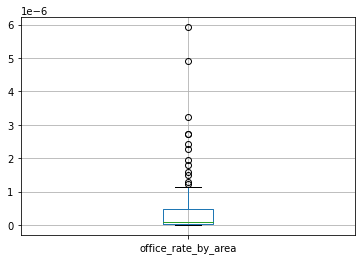

In [26]:
boxplot = merge_data.boxplot(column=['office_rate_by_area'])

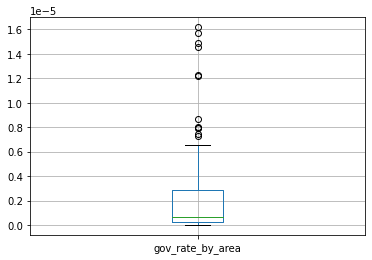

In [27]:
boxplot = merge_data.boxplot(column=['gov_rate_by_area'])

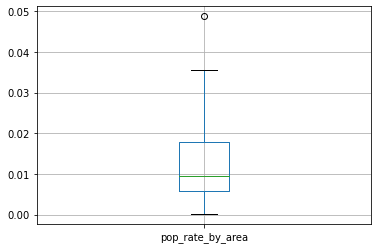

In [28]:
boxplot = merge_data.boxplot(column=['pop_rate_by_area'])

According to the above, the dependent variable meets the premise of linear regression, that is, it exhibits a normal distribution. In addition, through the box plots above, it can be found that the data sets have many outliers.
Ref: https://blog.csdn.net/u010462995/article/details/70847146

In [29]:
# temporarily useless code
#boxplot = merge_data.boxplot(column=['bus_arrive_in_15_min','cycling_arrive_in_15_min','walking_arrive_in_15_min','bus_arrive_area','cycling_arrive_area','walking_arrive_area','area','office_building','gov','population','bus_area_rate','cycling_area_rate','walking_area_rate','per_bus','per_cyc','per_walk','office_rate_by_area','gov_rate_by_area','pop_rate_by_area'])
#boxplot = merge_data.boxplot(['gov'])
#boxplot = merge_data.boxplot(column=['bus_arrive_in_15_min','cycling_arrive_in_15_min','walking_arrive_in_15_min'])
#boxplot = merge_data.boxplot(column=['bus_arrive_area','cycling_arrive_area','walking_arrive_area','area'])
#boxplot = merge_data.boxplot(column=['office_building','gov'])
#boxplot = merge_data.boxplot(column=['population'])
#boxplot = merge_data.boxplot(column=['per_bus','per_cyc','per_walk'])

In [30]:
merge_data2=merge_data[['walking_area_rate','office_rate_by_area','gov_rate_by_area','pop_rate_by_area']].copy()
merge_data2

,walking_area_rate,office_rate_by_area,gov_rate_by_area,pop_rate_by_area
0,0.565479,1.277502e-06,5.018759e-07,0.007560
1,0.787172,3.245404e-06,1.815226e-06,0.013214
2,0.029260,2.295843e-07,1.913202e-07,0.005934
3,0.000000,3.926148e-08,1.570459e-07,0.008370
4,0.099739,8.710281e-08,3.774455e-07,0.003235
...,...,...,...,...
69,0.000000,0.000000e+00,3.135211e-07,0.000643
70,0.331301,1.026236e-07,8.723002e-07,0.008523
71,0.383240,2.246670e-07,1.617602e-05,0.006474
72,0.077404,7.421470e-08,4.081809e-07,0.001702


### Drop outlier

In [31]:
# An outlier of a dataset is defined as a value that is more than 3 standard deviations away from the mean.
z_scores = stats.zscore(merge_data2)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
new_merge_data2 = merge_data2[filtered_entries]
new_merge_data2

,walking_area_rate,office_rate_by_area,gov_rate_by_area,pop_rate_by_area
0,0.565479,1.277502e-06,5.018759e-07,0.007560
1,0.787172,3.245404e-06,1.815226e-06,0.013214
2,0.029260,2.295843e-07,1.913202e-07,0.005934
3,0.000000,3.926148e-08,1.570459e-07,0.008370
4,0.099739,8.710281e-08,3.774455e-07,0.003235
...,...,...,...,...
68,0.162600,4.256707e-08,2.128354e-07,0.010264
69,0.000000,0.000000e+00,3.135211e-07,0.000643
70,0.331301,1.026236e-07,8.723002e-07,0.008523
72,0.077404,7.421470e-08,4.081809e-07,0.001702


### Regression

In [32]:
pd.set_option('display.max_rows', 80)
pd.options.display.float_format = '{:40,.4f}'.format
plt.style.use('ggplot')
%matplotlib inline

In [33]:
mix_num=pd.get_dummies(new_merge_data2)

In [34]:
mix_four=new_merge_data2.loc[:,['walking_area_rate','office_rate_by_area','gov_rate_by_area','pop_rate_by_area']]

In [35]:
# Notice is that, during multiple tests, gov_rate_by_area's p larger than 0.05.
mix_four2 = sm.formula.ols("walking_area_rate ~ office_rate_by_area + gov_rate_by_area + pop_rate_by_area", mix_four).fit()
mix_four2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      walking_area_rate   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     72.09
Date:                Fri, 08 Jul 2022   Prob (F-statistic):           8.58e-21
Time:                        10:43:48   Log-Likelihood:                 34.972
No. Observations:                  70   AIC:                            -61.94
Df Residuals:                      66   BIC:                            -52.95
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0143      0.030      0.471      0.639      -0.046       0.075
office_rate_by_area   1.61e+05   3.19e+04      5.048      0.000    9.73e+04    2.25e+05
gov_rate_by_area     1.889e+04   9543.693      1.979      0.052    -163.527    3.79e+04
pop_rate_by_area       14.3337      2.683      5.342      0.000       8.976      19.691
==============================================================================
Omnibus:                        9.715   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.008   Jarque-Bera (JB):                9.809
Skew:                           0.733   Prob(JB):                      0.00741
Kurtosis:                       4.101   Cond. No.                     1.79e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.19e-11. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### VIF

In [36]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant
def drop_column_using_vif_(df, thresh=5):
    while True:
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        vif_df = vif_df.drop('const')
        
        if vif_df.VIF.max() > thresh:
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            break

    return df

In [37]:
mix_new = drop_column_using_vif_(mix_four.drop('walking_area_rate', axis=1))
print(mix_new)

                        office_rate_by_area  \
0                                    0.0000   
1                                    0.0000   
2                                    0.0000   
3                                    0.0000   
4                                    0.0000   
5                                    0.0000   
6                                    0.0000   
7                                    0.0000   
8                                    0.0000   
9                                    0.0000   
10                                   0.0000   
11                                   0.0000   
12                                   0.0000   
13                                   0.0000   
14                                   0.0000   
15                                   0.0000   
16                                   0.0000   
17                                   0.0000   
18                                   0.0000   
19                                   0.0000   
20           

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


no VIF

### Expression

In [38]:
beta_0, beta_off, beta_gov, beta_pop = mix_four2.params
rsq= mix_four2.rsquared
arsq = mix_four2.rsquared_adj
pval_0, pval_1, pval_2, pval_3 = mix_four2.pvalues

print("walking_area_rate =", round(beta_off,3), "office_rate_by_area +", round(beta_gov,3), "gov_rate_by_area +", round(beta_pop,3), "pop_rate_by_area +",round(beta_0,3))
print("R^2     = ", rsq)
print("Adj.R^2 =", arsq)
print("p-value_log_gov = ", round(pval_1,3))
print("p-value_pop = ", round(pval_2,3))

walking_area_rate = 160993.468 office_rate_by_area + 18891.071 gov_rate_by_area + 14.334 pop_rate_by_area + 0.014
R^2     =  0.7661825690719333
Adj.R^2 = 0.7555545040297484
p-value_log_gov =  0.0
p-value_pop =  0.052


### Visualisation

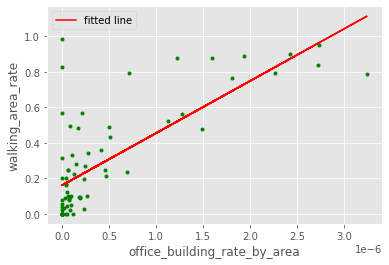

y = 293165.049 x + 0.162
Rsq =  0.5500523318002977
p-value =  2.072316931508612e-13


In [39]:
X = new_merge_data2['office_rate_by_area']
Y = new_merge_data2['walking_area_rate']

a = plt.plot(X,Y,'g.')
plt.xlabel('office_building_rate_by_area')
plt.ylabel('walking_area_rate')

slope, intercept, r_value, p_value, std_err = sps.linregress(X, Y) 

b = plt.plot(X, X*slope + intercept, 'r', label='fitted line')
plt.legend()
plt.show()

print("y =", round(slope,3), "x +", round(intercept,3))
print("Rsq = ", r_value**2)
print("p-value = ", p_value)

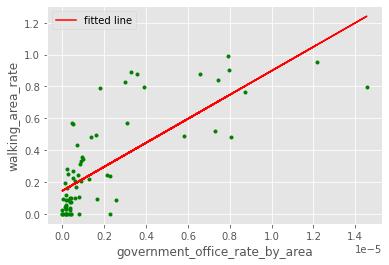

y = 75255.315 x + 0.145
Rsq =  0.5629835948301205
p-value =  7.604508318660681e-14


In [40]:
X = new_merge_data2['gov_rate_by_area']
Y = new_merge_data2['walking_area_rate']

a = plt.plot(X,Y,'g.')
plt.xlabel('government_office_rate_by_area')
plt.ylabel('walking_area_rate')

slope, intercept, r_value, p_value, std_err = sps.linregress(X, Y) 

b = plt.plot(X, X*slope + intercept, 'r', label='fitted line')
plt.legend()
plt.show()

print("y =", round(slope,3), "x +", round(intercept,3))
print("Rsq = ", r_value**2)
print("p-value = ", p_value)

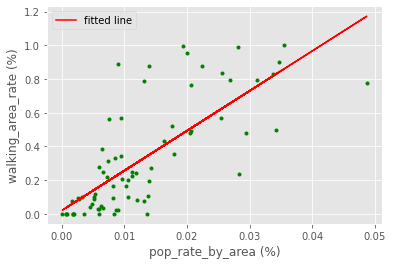

y = 23.65 x + 0.02
Rsq =  0.5671445844104012
p-value =  9.974460138859445e-15


In [41]:
X = merge_data['pop_rate_by_area']
Y = merge_data['walking_area_rate']

a = plt.plot(X,Y,'g.')

plt.xlabel('pop_rate_by_area (%)')
plt.ylabel('walking_area_rate (%)')

slope, intercept, r_value, p_value, std_err = sps.linregress(X, Y) 

b = plt.plot(X, X*slope + intercept, 'r', label='fitted line')
plt.legend()
plt.show()

print("y =", round(slope,3), "x +", round(intercept,3))
print("Rsq = ", r_value**2)
print("p-value = ", p_value)

In [42]:
new_merge_data2['pre']=162656.516*new_merge_data2['office_rate_by_area'] + 18605.986*new_merge_data2['gov_rate_by_area'] + 14.339*new_merge_data2['pop_rate_by_area'] + 0.013

/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


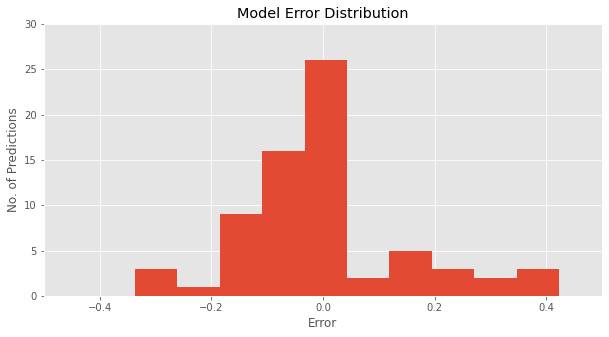

In [43]:
new_merge_data2['error'] = new_merge_data2['walking_area_rate'] - new_merge_data2['pre']

#Set plot size
plt.subplots(figsize=(10,5))
#Set X-Axis range
plt.xlim(-0.5, 0.5)
plt.ylim(0, 30)
plt.title('Model Error Distribution')
plt.ylabel('No. of Predictions')
plt.xlabel('Error')
plt.hist(new_merge_data2['error']);
plt.show()

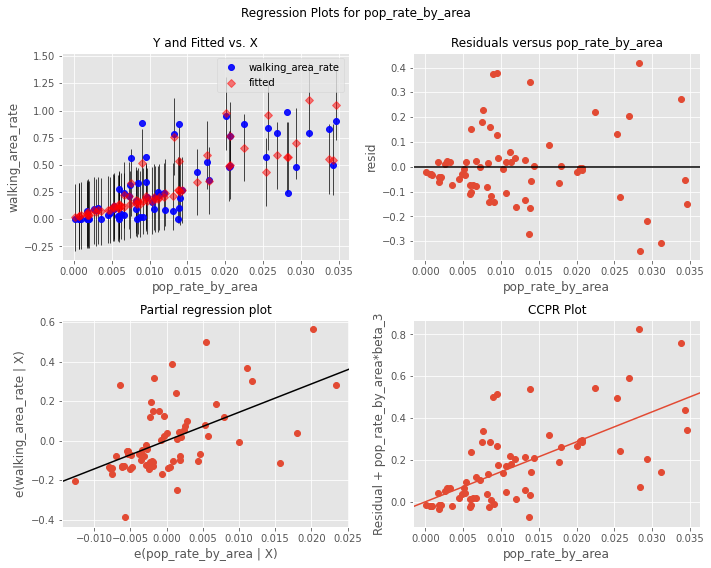

In [44]:
fig = plt.figure(figsize=(10,8))
fig = sm.graphics.plot_regress_exog(mix_four2, 'pop_rate_by_area', fig=fig)

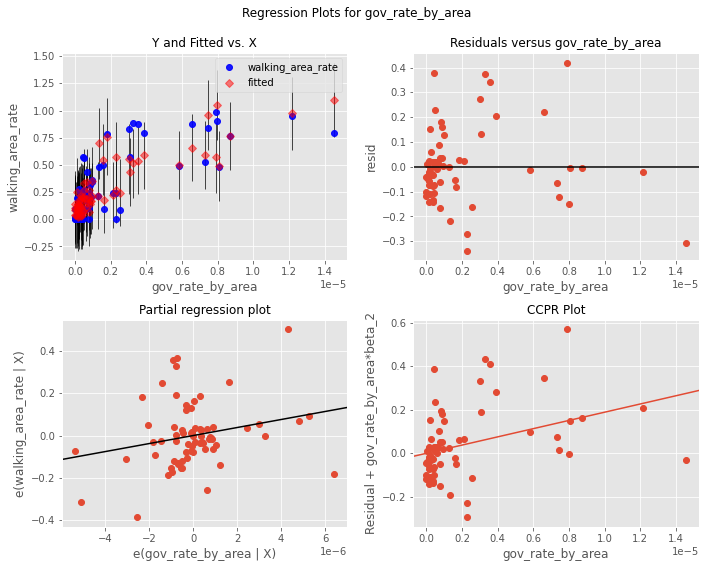

In [45]:
fig = plt.figure(figsize=(10,8))
fig = sm.graphics.plot_regress_exog(mix_four2, 'gov_rate_by_area', fig=fig)

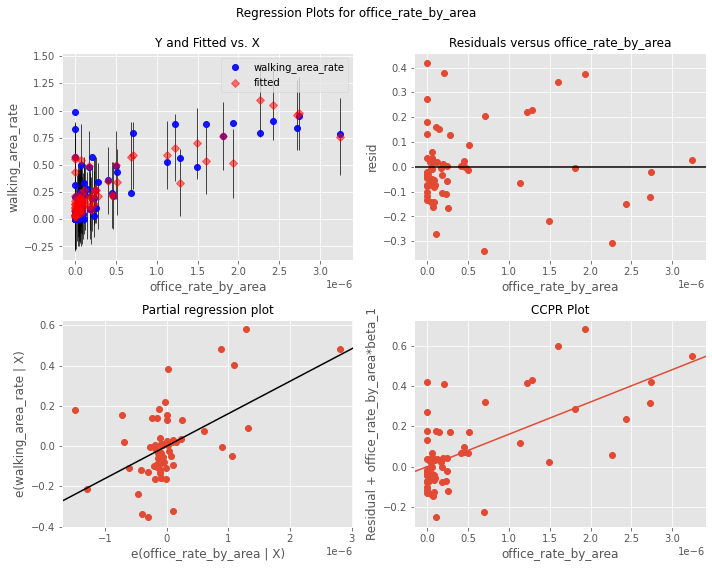

In [46]:
fig = plt.figure(figsize=(10,8))
fig = sm.graphics.plot_regress_exog(mix_four2, 'office_rate_by_area', fig=fig)

In [52]:
merge_data.to_csv('output_data/Q1_final.csv')

In [53]:
mix.to_file('output_data/Q1_final.shp')

/tmp/ipykernel_109/1467789726.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  mix.to_file('output_data/Q1_final.shp')
